In [1]:
!pip install scikit-learn
!pip install minisom
!pip install console_progressbar

In [18]:
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar

In [19]:
def setup_working_directories():
    """Clean up and recreate working directories"""
    working_dir = 'working/data'
    
    if os.path.exists(working_dir):
        print("Removing existing working directory...")
        shutil.rmtree(working_dir)
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(working_dir, split)
        ensure_folder(split_dir)
    
    print("Working directories initialized.")

def save_split_data(data, split_name, src_folders):
    """Save images for a specific data split"""
    print(f"Processing {split_name} split...")
    dst_folder = f'working/data/{split_name}'

In [20]:
def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        
def save_train_data(fnames, labels, bboxes):
    src_folder ='stanford-cars-dataset/cars_train/cars_train/'
    num_samples = len(fnames)
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = int(max(0, float(x1) - margin))
        y1 = int(max(0, float(y1) - margin))
        x2 = int(min(float(x2) + margin, width))
        y2 = int(min(float(y2) + margin, height))
        # print("{} -> {}".format(fname, label)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = 'working/data/train/'
        else:
            dst_folder = 'working/data/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]

        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        
def save_test_data(fnames, bboxes):
    src_folder = 'stanford-cars-dataset/cars_test/cars_test/'
    dst_folder = 'working/data/test/'
    num_samples = len(fnames)
    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = int(max(0, float(x1) - margin))
        y1 = int(max(0, float(y1) - margin))
        x2 = int(min(float(x2) + margin, width))
        y2 = int(min(float(y2) + margin, height))
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('cars-devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)

def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('cars-devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

In [21]:
img_width, img_height = 224, 224
setup_working_directories()

cars_meta = scipy.io.loadmat('cars-devkit/cars_meta.mat')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))

ensure_folder('working/data/train')
ensure_folder('working/data/valid')
ensure_folder('working/data/test')

process_train_data()
process_test_data()

Removing existing working directory...
Working directories initialized.
class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different

In [22]:
counter_images_train = 0
counter_images_valid = 0
train_folder = 'working/data/train'
valid_folder = 'working/data/valid'

for i in os.listdir(train_folder):
    counter_images_train += len(os.listdir(os.path.join(train_folder, i)))
    
for i in os.listdir(valid_folder):
    counter_images_valid += len(os.listdir(os.path.join(valid_folder, i)))
    
print("Train:", counter_images_train)
print("Valid:", counter_images_valid)
print("Test:", len(os.listdir('working/data/test')))


Train: 6515
Valid: 1629
Test: 8041


In [23]:
import torchvision
import pandas as pd
import torch
import os
import seaborn as sns
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# tot_images_viz = no. of images that you want to visualize from each class
# num_class = no. of classes that you want to visualize

tot_images_viz,num_classes,img_size = 10, 16, 224

train_im_dir = './working/data/train/'
img_paths = [train_im_dir + str(i).zfill(4) + '/' + fn for i in range(1,5) \
                 for fn in os.listdir(train_im_dir + str(i).zfill(4))[:tot_images_viz] ]    
    
img_dict = {}
for i in range(1,num_classes+1):
    img_dict[i] = list(map(lambda x: train_im_dir + str(i).zfill(4) + '/' + x,
                      os.listdir(train_im_dir + str(i).zfill(4))[:tot_images_viz]))

def im2tensor(file_names,bs=num_classes):
    all_im = torch.zeros((bs,3,img_size,img_size))
    custom_transform = transforms.Compose([transforms.Resize((img_size, img_size)),                                           
                                           transforms.ToTensor()])
    for i,fn in enumerate(file_names):
        all_im[i,:,:,:] = (custom_transform(Image.open(fn)))
        
    return all_im

MovieWriter ffmpeg unavailable; using Pillow instead.


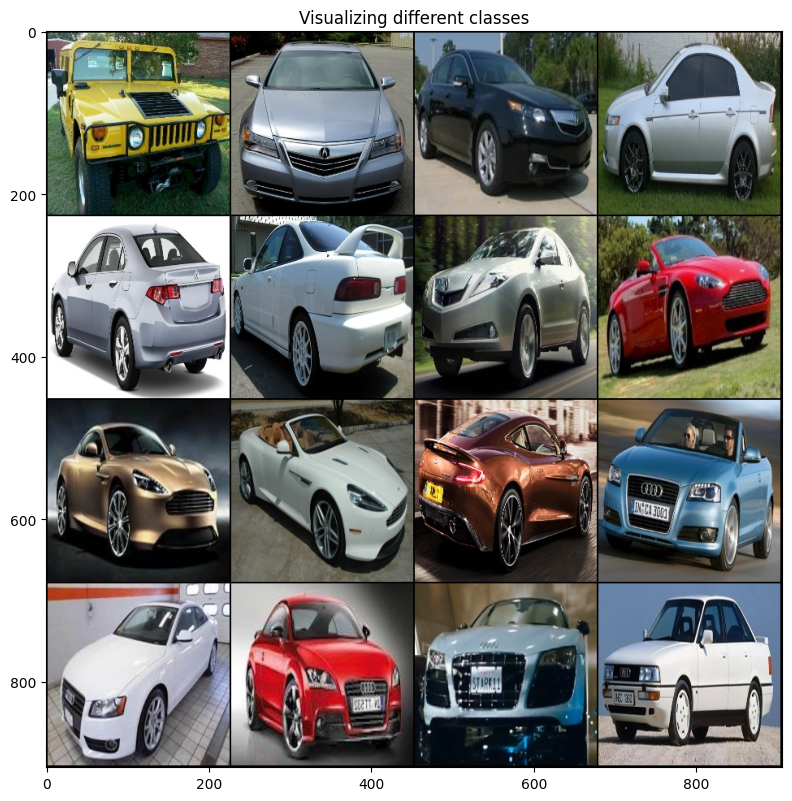

In [25]:
fig = plt.figure(figsize=(8,8))
imgs = []
class_name_list = scipy.io.loadmat('stanford-cars-dataset/cars_annos.mat')['class_names'].flatten()
class_name_list = list(map(lambda x: x[0],class_name_list))

for i in range(0,tot_images_viz):
    fn = [img_dict[j][i] for j in range(1,num_classes+1)]
    all_im = im2tensor(fn)
    
    grid = torchvision.utils.make_grid(all_im,4)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im = plt.imshow(im, animated=True) 
    imgs.append([im])

ani = animation.ArtistAnimation(fig, imgs, interval=1000, blit=True,
                                repeat_delay=1000)
plt.tight_layout()
plt.title('Visualizing different classes')

ani.save('car_images.gif')

       class_count
count   196.000000
mean     33.239796
std       4.288165
min      21.000000
25%      31.000000
50%      34.000000
75%      36.000000
max      55.000000
Class with min count: 98
Class with max count: 118


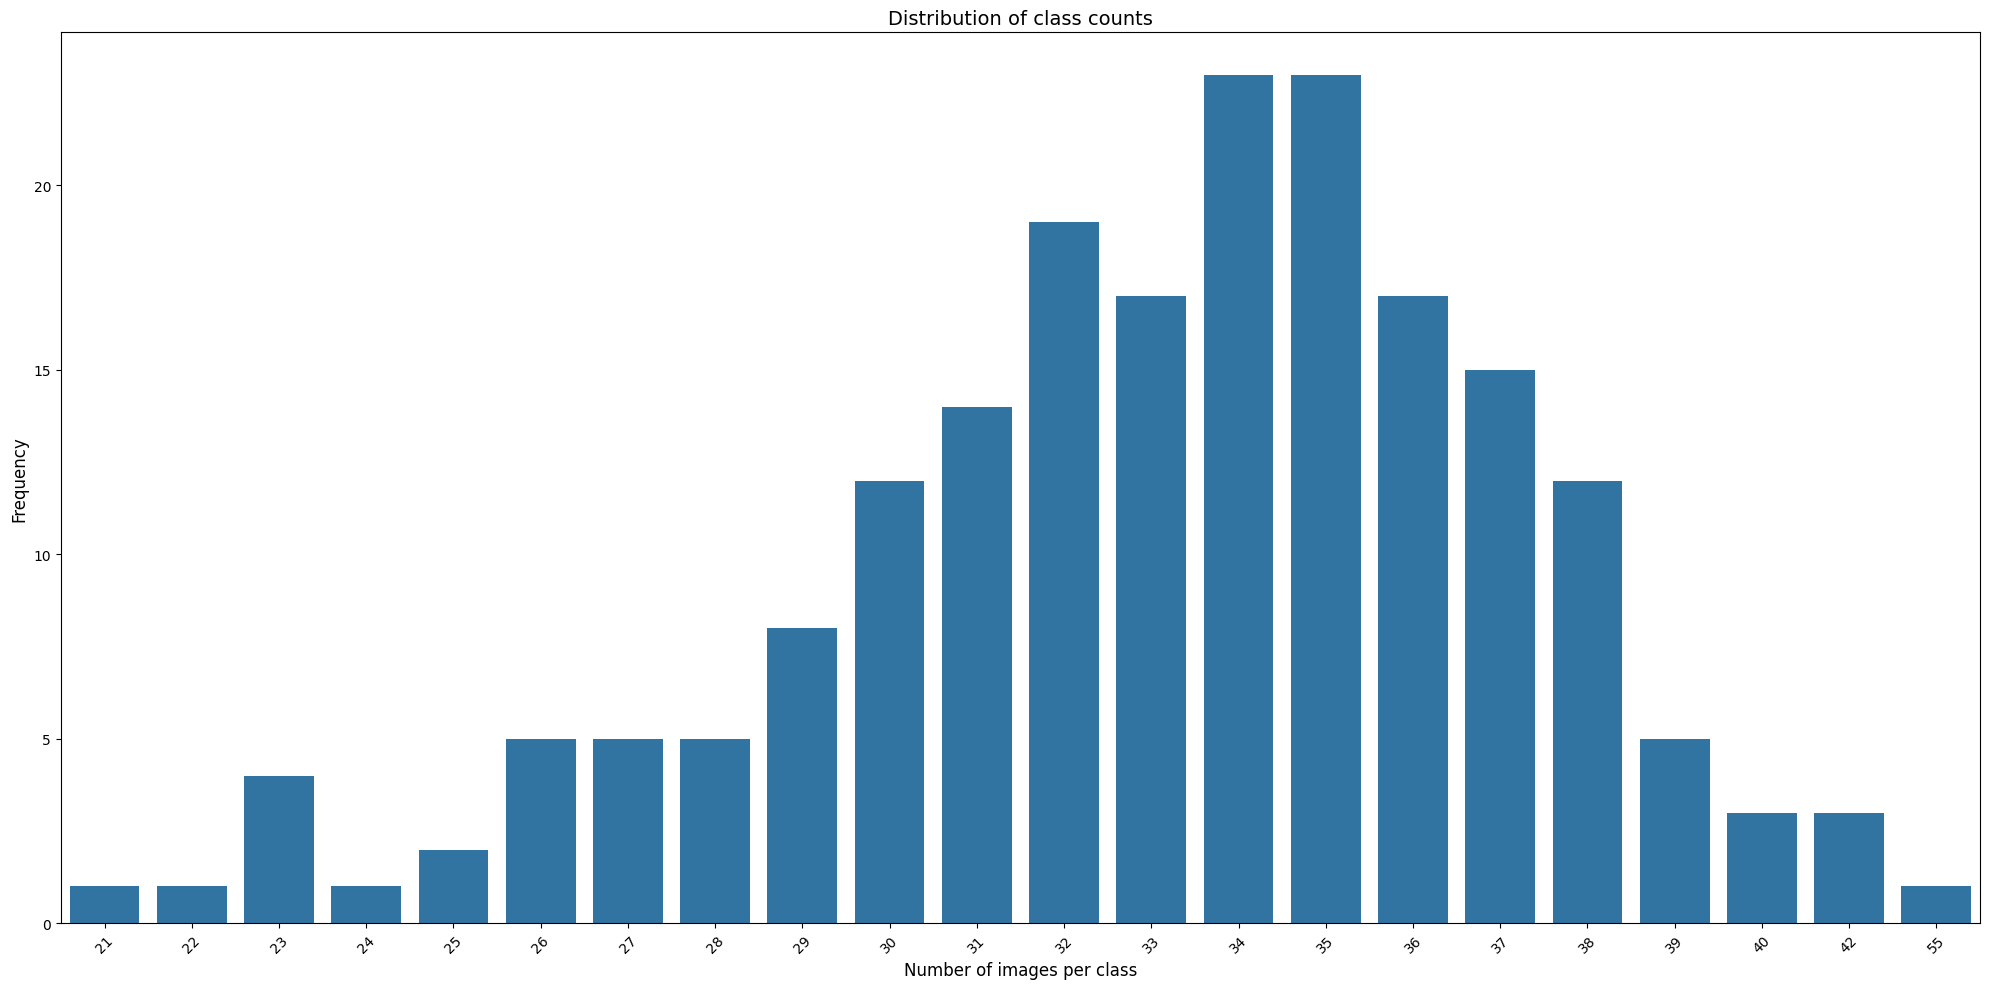

In [26]:
all_img_dict = {}
num_class_visualize,class_count = 196,[]
for i in range(1,num_class_visualize+1):
    class_count.append(len(os.listdir(train_im_dir + str(i).zfill(4))))

class_count = np.array(class_count)
class_count_df = pd.DataFrame(class_count,columns=['class_count'])

print(class_count_df.describe())
print('Class with min count:', class_count.argmin())
print('Class with max count:', class_count.argmax())

plt.figure(figsize=(20, 10))
sns.countplot(data=class_count_df, x='class_count')  # Explicitly specify data and x
plt.title('Distribution of class counts', fontsize=14)
plt.xlabel('Number of images per class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

In [27]:
all_img_dict = {}
num_class_visualize = 196
for i in range(1,num_class_visualize+1):
    all_img_dict[i] = list(map(lambda x: train_im_dir + str(i).zfill(4) + '/' + x,
                      os.listdir(train_im_dir + str(i).zfill(4))))

images = []
labels = []
resized_img_size = 224

for class_name, file_names in all_img_dict.items():
    for fn in file_names:
        image = np.array(Image.open(fn))
        image = cv.resize(image, (resized_img_size, resized_img_size))
        images.append(image)
        labels.append(class_name)

images = np.array(images) 
labels = np.array(labels)

print(f"Images shape: {images.shape}")
images_torch = np.transpose(images, (0, 3, 1, 2))
print(f"PyTorch format shape: {images_torch.shape}")

Images shape: (6515, 224, 224, 3)
PyTorch format shape: (6515, 3, 224, 224)


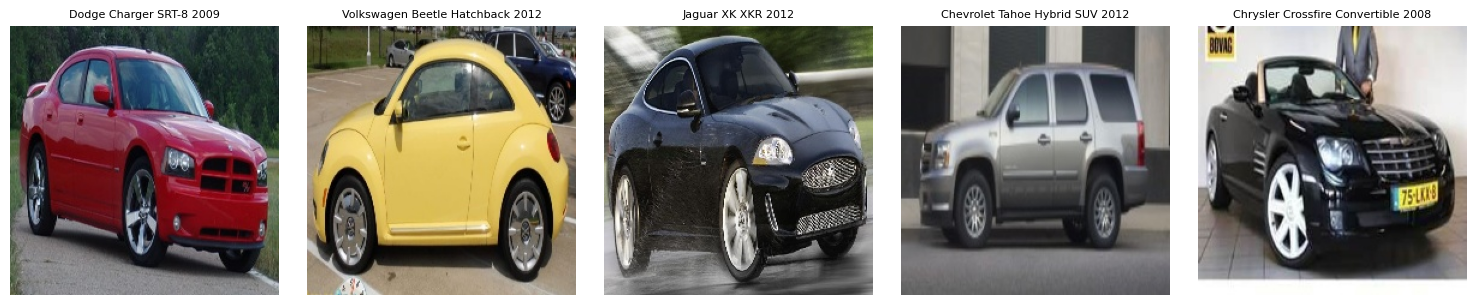

In [29]:
# print some random images
plt.figure(figsize=(15, 3))
random_indices = np.random.choice(len(images), 5)

for idx, i in enumerate(random_indices):
    plt.subplot(1, 5, idx+1)
    img = images[i].reshape(resized_img_size, resized_img_size, 3)
    plt.imshow(img.astype('uint8'))
    car_name = class_name_list[labels[i]-1]
    plt.title(f'{car_name}', fontsize=8, wrap=True)
    plt.axis('off')

plt.tight_layout()
plt.show()